In [1]:
import os
import sys
import torch
import random
import argparse
import numpy as np
import scipy
from matplotlib import pyplot
import numpy
from jax import numpy as jnp
from jax.config import config
# config.update("jax_debug_nans", True)
config.update("jax_enable_x64", True)

sys.path.append('../../timeseries_jax/')
sys.path.append('../../timeseries/experiments_scripts/')
sys.path.append('../../src_jax/')

import factors
import state_models
import observation_models
from ssm_em import StateSpaceEM
#from nonlinear_ssm import NonLinearStateSpace_EM

from scipy.stats import norm
from scipy.stats import zscore
from ssm_em import StateSpaceEM, load_model
from sklearn.covariance import EmpiricalCovariance
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.gaussian_process.kernels import ExpSineSquared, RBF

from exp_utils import *

'''
sys.path.append('../../timeseries/kalman-jax-master')
from jax.experimental import optimizers
#from sde_gp import SDEGP
import approximate_inference as approx_inf
import priors
import likelihoods
from utils import softplus_list, plot
'''
def reset_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
def train_linear_SSM(x_tr, dz, init_w_pca=False, smooth_window=20):

    dx = x_tr.shape[1]
    sm = state_models.LinearStateModel(dz)
    om = observation_models.LinearObservationModel(dx, dz)
    
    if init_w_pca == 1:
        om.pca_init(x_tr, smooth_window=smooth_window)
        
    ssm_em_lin = StateSpaceEM(jnp.array(x_tr), observation_model=om, state_model=sm)
    ssm_em_lin.run()
    
    return ssm_em_lin


def train_linear_hsk_SSM(x_tr, dz, du, init_w_pca=False, smooth_window=20):

    dx = x_tr.shape[1]
    sm_hs = state_models.LinearStateModel(dz)
    om_hs = observation_models.HCCovObservationModel(dx, dz, du)
    if init_w_pca == 1:
        om_hs.pca_init(x_tr, smooth_window=20)
    hs_model = StateSpaceEM(jnp.array(x_tr), observation_model=om_hs, state_model=sm_hs, max_iter=1000)
    hs_model.run()
    
    return hs_model

In [2]:
U = jnp.array([[ 0.80261222, -0.13177146,  0.11394815,],
               [ 0.12992903,  0.02199786, -0.99107259],
               [ 0.25840931, -0.79536608,  0.00502645],
               [ 0.52168639,  0.59122345,  0.0690339 ]])
jnp.dot(U.T,U)

DeviceArray([[9.99999990e-01, 3.95227533e-09, 4.91297579e-09],
             [3.95227533e-09, 9.99999993e-01, 2.51768259e-09],
             [4.91297581e-09, 2.51768259e-09, 1.00000000e+00]],            dtype=float64)

In [2]:
dz, du = 1, 1

In [4]:
seed = 0
reset_seeds(seed)
x_tr, x_va, x_te, x_te_na, s_tr_x = load_sunspots_e1()
ssm_em_lin = train_linear_SSM(x_tr, dz, init_w_pca=False)
ssm_em_lin.save(model_name='ssm_em_lin_sunspots', path='../../data/models/')

Iteration 1 - llk=-1816.0
Iteration 2 - llk=-1163.8
Iteration 3 - llk=-882.7
Iteration 4 - llk=-729.2
Iteration 5 - llk=-663.8
Iteration 6 - llk=-641.1
Iteration 7 - llk=-634.1
Iteration 8 - llk=-631.9
Iteration 9 - llk=-630.9
Iteration 10 - llk=-630.3
Iteration 11 - llk=-629.9
Iteration 12 - llk=-629.5
Iteration 13 - llk=-629.2
Iteration 14 - llk=-629.0
EM did converge.


In [3]:
seed = 0
reset_seeds(seed)
x_tr, x_va, x_te, x_te_na, s_tr_x = load_sunspots_e1()
ssm_em_hsk = train_linear_hsk_SSM(x_tr, dz, du, init_w_pca=False)
ssm_em_hsk.save(model_name='ssm_em_hsk_sunspots', path='../../data/models/')

Iteration 1 - llk=-2243.7
Iteration 2 - llk=-1265.6
Iteration 3 - llk=-911.6
Iteration 4 - llk=-740.5
Iteration 5 - llk=-667.5
Iteration 6 - llk=-641.2
Iteration 7 - llk=-620.5
Iteration 8 - llk=-591.8
Iteration 9 - llk=-571.5
Iteration 10 - llk=-558.1
Iteration 11 - llk=-548.4
Iteration 12 - llk=-541.0
Iteration 13 - llk=-534.9
Iteration 14 - llk=-529.8
Iteration 15 - llk=-525.5
Iteration 16 - llk=-521.7
Iteration 17 - llk=-518.5
Iteration 18 - llk=-515.6
Iteration 19 - llk=-513.1
Iteration 20 - llk=-510.8
Iteration 21 - llk=-508.8
Iteration 22 - llk=-507.0
Iteration 23 - llk=-505.4
Iteration 24 - llk=-504.0
Iteration 25 - llk=-502.6
Iteration 26 - llk=-501.4
Iteration 27 - llk=-500.3
Iteration 28 - llk=-499.3
Iteration 29 - llk=-498.3
Iteration 30 - llk=-497.4
Iteration 31 - llk=-496.6
Iteration 32 - llk=-495.9
Iteration 33 - llk=-495.1
Iteration 34 - llk=-494.5
Iteration 35 - llk=-494.1
Iteration 36 - llk=-494.0
Iteration 37 - llk=-493.8
EM did converge.


In [4]:
params = ssm_em_hsk.om.params_to_vector(ssm_em_hsk.om.C, ssm_em_hsk.om.d, ssm_em_hsk.om.U, ssm_em_hsk.om.sigma_x, ssm_em_hsk.om.beta, ssm_em_hsk.om.W)
ssm_em_hsk.om.C, ssm_em_hsk.om.d, ssm_em_hsk.om.U, ssm_em_hsk.om.sigma_x, ssm_em_hsk.om.beta, ssm_em_hsk.om.W

(DeviceArray([[2.90639195]], dtype=float64),
 DeviceArray([-0.30063575], dtype=float64),
 DeviceArray([[1.]], dtype=float64),
 DeviceArray([0.17247853], dtype=float64),
 DeviceArray([0.00743721], dtype=float64),
 DeviceArray([[0.       , 7.2818909]], dtype=float64))

In [5]:
ssm_em_hsk.om.vector_to_params(params, ssm_em_hsk.om.Dx, ssm_em_hsk.om.Dz, ssm_em_hsk.om.Dx)

(DeviceArray([[0.40141447]], dtype=float64),
 DeviceArray([0.00124887], dtype=float64),
 DeviceArray([[1.]], dtype=float64),
 DeviceArray([0.23538889], dtype=float64),
 DeviceArray([0.01385198], dtype=float64),
 DeviceArray([[0.00000000e+00, 1.55291372e-08]], dtype=float64))

In [10]:
ssm_em_hsk.om.W

DeviceArray([[0.69965587, 0.94192776]], dtype=float64)

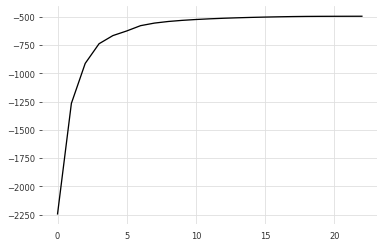

In [4]:
pyplot.plot(ssm_em_hsk.llk_list)

In [5]:
ssm_em_hsk.om.beta / ssm_em_hsk.om.sigma_x ** 2

DeviceArray([0.24860576], dtype=float64)

In [6]:
ssm_em_hsk.om.beta, ssm_em_hsk.om.sigma_x

(DeviceArray([0.0058218], dtype=float64),
 DeviceArray([0.15302881], dtype=float64))

In [ ]:
ssm_em_hsk = load_model(model_name='ssm_em_hsk_energy', path='../../data/models/')
ssm_em_lin = load_model(model_name='ssm_em_lin_energy', path='../../data/models/')

In [7]:
ssm_em_lin.compute_predictive_log_likelihood(jnp.array(x_te))

DeviceArray(-730.50023397, dtype=float64)

In [8]:
ssm_em_hsk.compute_predictive_log_likelihood(jnp.array(x_te))

DeviceArray(-618.80580889, dtype=float64)

In [9]:
pred_hsk = ssm_em_hsk.compute_predictive_density(x_te)
pred_lin = ssm_em_lin.compute_predictive_density(x_te)

Text(0.5, 0, 'Time steps')

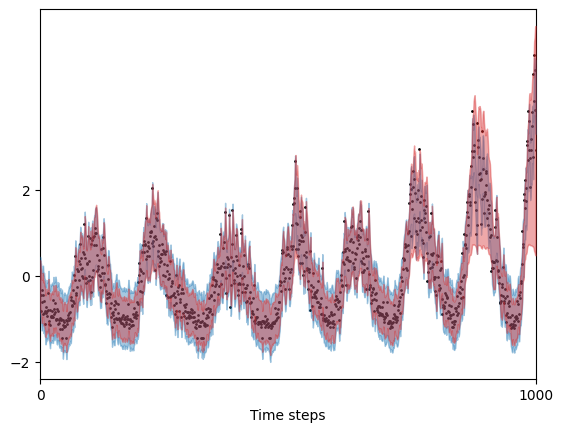

In [10]:
pyplot.rcdefaults()
mu_hsk, std_hsk = pred_hsk.mu, numpy.sqrt(pred_hsk.Sigma.diagonal(axis1=1, axis2=2))
mu_lin, std_lin = pred_lin.mu, numpy.sqrt(pred_lin.Sigma.diagonal(axis1=1, axis2=2))


fig = pyplot.figure()
start_idx = 100
for idx in range(1):
    ax = fig.add_subplot(1,1,idx+1)
    pyplot.plot(x_te[start_idx:1000+ start_idx,idx], 'k.', ms=2)
    pyplot.fill_between(range(1000), mu_hsk[start_idx:1000+ start_idx,idx] - 1.68 * std_hsk[start_idx:1000+ start_idx,idx], mu_hsk[start_idx:1000+ start_idx,idx] + 1.68 * std_hsk[start_idx:1000+ start_idx,idx], color='C3', alpha=.4, zorder=9, label='heterosk.')
    pyplot.fill_between(range(1000), mu_lin[start_idx:1000+ start_idx,idx] - 1.68 * std_lin[start_idx:1000+ start_idx,idx], mu_lin[start_idx:1000+ start_idx,idx] + 1.68 * std_lin[start_idx:1000+ start_idx,idx], color='C0', alpha=.4, zorder=7, label='homosk.')
    pyplot.xlim([0,1000])
    pyplot.xticks([0,1000], labels=[])
    pyplot.yticks([-2,0,2])
    #pyplot.ylim([-3,3])
pyplot.xticks([0,1000], labels=[0,1000])
#pyplot.legend(frameon=False)
idx = 2
pyplot.xlabel('Time steps')
#pyplot.plot(mu_hsk[:1000,idx], color='C0')
#pyplot.plot(mu_hsk[:1000,idx], color='C3')